<a href="https://colab.research.google.com/github/Gabriel-Mourad/Madurity-lemon-estimator-TFG/blob/main/Mask_RCNN_INFERENCE_LEMONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/TFG

Mounted at /gdrive
/gdrive/MyDrive/TFG


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip list

In [ ]:
!pip uninstall h5py
!pip install h5py==2.10.0

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
!pip3 install -3 requeriments.txt
!python3 setup.py install

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../

In [ ]:
import os 
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import imgaug



# Directorio de trabajo
ROOT_DIR = '/gdrive/MyDrive/TFG/projects/software/Mask_RCNN'


sys.path.append(ROOT_DIR)

# De la carpeta MRCNN importem:

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

# Directorio para guardar el modelo con su configuracion interna
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directorio del modelo pre-etrenado
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "logs/mask_rcnn_coco.h5")


Using TensorFlow backend.


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [ ]:
DATA_DIR = "/gdrive/MyDrive/TFG/projects/data"

DATASET_TRAIN_DIR = os.path.join(DATA_DIR, 'train')
DATASET_VAL_DIR = os.path.join(DATA_DIR, 'val')
DATASET_TEST_DIR = os.path.join(DATA_DIR, 'test')

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

CONFIGURATION

In [ ]:
class LemonsConfig( Config ):
  
  NAME = 'Lemons'
  IMAGES_PER_GPU = 1
  NUM_CLASSES = 1 + 1 + 1 + 1 # BACKGROUND + VERDE + MADURO + PODRIDO
  STEPS_PER_EPOCH = 1950 #tambien se pueden poner el mismo numero de fotos que hay en el train set
  DETECTION_MIN_CONFIDENCE = 0.8

config = LemonsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
from PIL import Image, ImageDraw
axis_Width = 15

DATASET

In [ ]:
class LemonsDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        self.add_class('dataset', 1, 'VERDE')
        self.add_class('dataset', 2, 'MADURO')
        self.add_class('dataset', 3, 'PODRIDO')        
        # find all images
        for i, filename in enumerate(os.listdir(dataset_dir)):
            annotation_file = os.path.join(dataset_dir, filename.replace('.jpg', '.json'))
            if '.jpg' in filename and os.path.isfile(annotation_file):
                    self.add_image('dataset',
                               image_id=i,
                               path=os.path.join(dataset_dir, filename),
                               annotation=annotation_file)
   

    def extract_masks(self, filename):
        json_file = os.path.join(filename)
        with open(json_file) as f:
            img_anns = json.load(f)
       
        n_masks = 0
        for anno in img_anns['shapes']:
            if anno['label']=='VERDE' or anno['label']=='MADURO' or anno['label']=='PODRIDO':
                n_masks+=1
           
        masks = np.zeros([img_anns['imageHeight'], img_anns['imageWidth'], n_masks], dtype='uint8')
        classes = []
        i=0
        for anno in img_anns['shapes']:
            if anno['label']=='VERDE' or anno['label']=='MADURO' or anno['label']=='PODRIDO':
                mask = np.zeros([img_anns['imageHeight'], img_anns['imageWidth']], dtype=np.uint8)            
                cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
                masks[:, :, i] = mask
                classes.append(self.class_names.index(anno['label']))
                i+=1
        return masks, classes
   

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load masks
        masks, classes = self.extract_masks(path)
        return masks, np.asarray(classes, dtype='int32')
   
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [ ]:
# CREATE DATASET


# test set

dataset_test = LemonsDataset()
dataset_test.load_dataset(DATASET_TEST_DIR)
dataset_test.prepare()

print("Image Count: {}".format(len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
  print("{:3}.  {:50}".format(i, info['name']))

# val set

dataset_val = LemonsDataset()
dataset_val.load_dataset(DATASET_VAL_DIR)
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
  print("{:3}.  {:50}".format(i, info['name']))

Image Count: 557
Class Count: 4
  0.  BG                                                
  1.  VERDE                                             
  2.  MADURO                                            
  3.  PODRIDO                                           
Image Count: 278
Class Count: 4
  0.  BG                                                
  1.  VERDE                                             
  2.  MADURO                                            
  3.  PODRIDO                                           


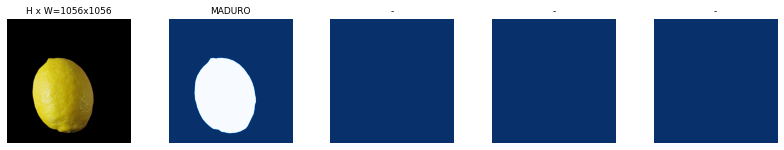

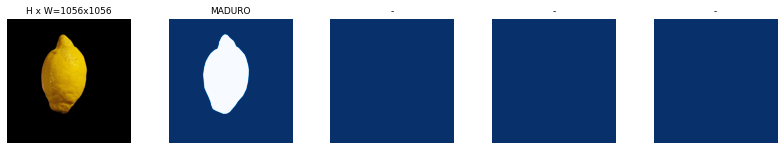

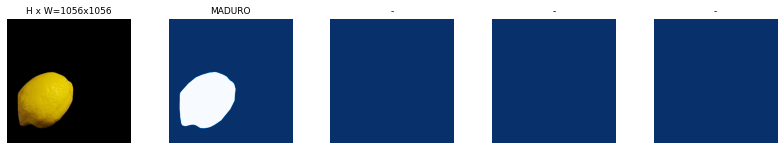

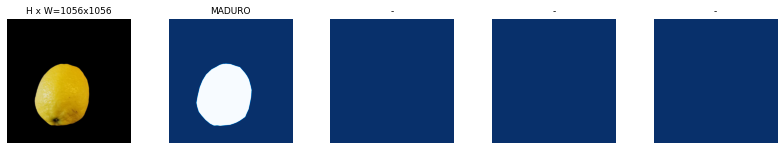

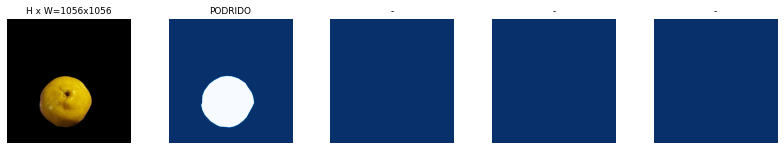

In [ ]:
image_ids = np.random.choice(dataset_test.image_ids, 5)
for image_id in image_ids:
  image = dataset_test.load_image(image_id)
  mask, class_ids = dataset_test.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

In [ ]:
%load_ext tensorboard

INFERENCIA

In [ ]:
class InferenceConfig(LemonsConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [ ]:
# CREATE INFERENCE MODEL

model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

model_path = model.find_last()
print("Loading weigths from: ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
def get_ax(rows=1, cols=1, size=8):
  _,ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

In [ ]:
dataset_test.image_ids

In [ ]:
#TEST IN RANDOM IMAGE
#image_id = np.random.choice(dataset_test.image_ids)
image_id = 274
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_test.class_names, figsize=(8, 8))

print(gt_class_id.shape)

In [ ]:
start_time = time.time()
results = model.detect([original_image], verbose=1)
print("--- %s seconds ---" % (time.time() - start_time))
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())#foto
print(r['class_ids'].shape)